# Redes Neurais Artificiais

## Desenvolvimento
O notebook foi desenvolvido pelos estudantes
- TAMYRIS CABRAL GOMES ROCHA - 202204193
- MARCOS VINÍCIUS SILVA - 202204192

### Objetivo do Notebook
Este notebook demonstra a utilização de redes neurais para prever os preços de imóveis residenciais, com base no conjunto de dados "House Prices" disponível no Kaggle. O principal objetivo é aplicar métodos de machine learning para estimar o valor de venda das casas a partir de suas características. O processo inclui etapas de pré-processamento dos dados, construção e treinamento dos modelos, avaliação dos resultados e geração das previsões para submissão na plataforma.

### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import random
import os
from tqdm import tqdm
import torch.optim as optim
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go


### Hiperparâmetros

In [ ]:
EPOCHS = 500
LEARNING_RATE = 0.001
BATCH_SIZE = 64
DEVICE = 'cpu'

### Seeds

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ["PYTHONHASHSEED"] = str(SEED)

## Tratamento dos dados

In [ ]:
url_train = '/content/train.csv'
df = pd.read_csv(url_train)

#df['Id_original'] = df['Id']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Medidas da coluna target

In [ ]:
print('Média de preço dos imóveis: ', round(df['SalePrice'].mean(), 2))
print('Mediana dos preços dos imóveis: ', df['SalePrice'].median())
print('Desvio padrão: ', round(df['SalePrice'].std(), 2))
print('Preço mínimo: ', df['SalePrice'].min())
print('Preço máximo: ', df['SalePrice'].max())


Média de preço dos imóveis:  180921.2
Mediana dos preços dos imóveis:  163000.0
Desvio padrão:  79442.5
Preço mínimo:  34900
Preço máximo:  755000


### Porcentagem de valores ausentes por coluna
Em nossa AED é extremamente importante tratar dados faltantes/nulos. Precisamos verificar quais colunas possuem maior porcentagem de dados nulos.
Para essa análise escolhemos tirar as colunas com pelo menos 20% de todos os dados nulos, visto que a amostragem não nula (que será utilizada para tratamento dos dados) pode não representar muito bem os dados de forma real

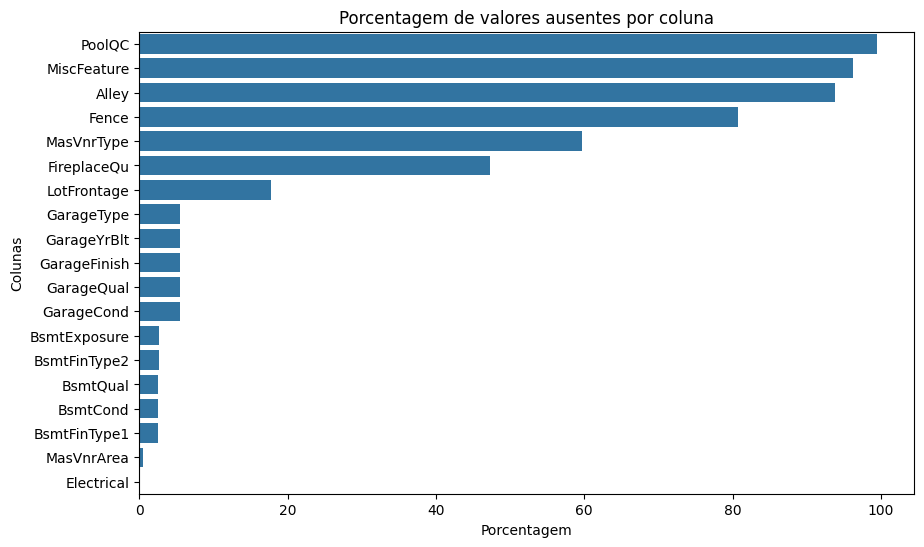

In [ ]:
nulos = df.isnull().sum() / len(df) * 100
nulos = nulos[nulos > 0].sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=nulos.values, y=nulos.index)
plt.title('Porcentagem de valores ausentes por coluna')
plt.xlabel('Porcentagem')
plt.ylabel('Colunas')
plt.show()

In [ ]:
colunas_remover = [
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu',
    'LotFrontage',
    'Id'
]

df.drop(columns=colunas_remover, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotArea        1460 non-null   int64  
 3   Street         1460 non-null   object 
 4   LotShape       1460 non-null   object 
 5   LandContour    1460 non-null   object 
 6   Utilities      1460 non-null   object 
 7   LotConfig      1460 non-null   object 
 8   LandSlope      1460 non-null   object 
 9   Neighborhood   1460 non-null   object 
 10  Condition1     1460 non-null   object 
 11  Condition2     1460 non-null   object 
 12  BldgType       1460 non-null   object 
 13  HouseStyle     1460 non-null   object 
 14  OverallQual    1460 non-null   int64  
 15  OverallCond    1460 non-null   int64  
 16  YearBuilt      1460 non-null   int64  
 17  YearRemodAdd   1460 non-null   int64  
 18  RoofStyl

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'Kitch

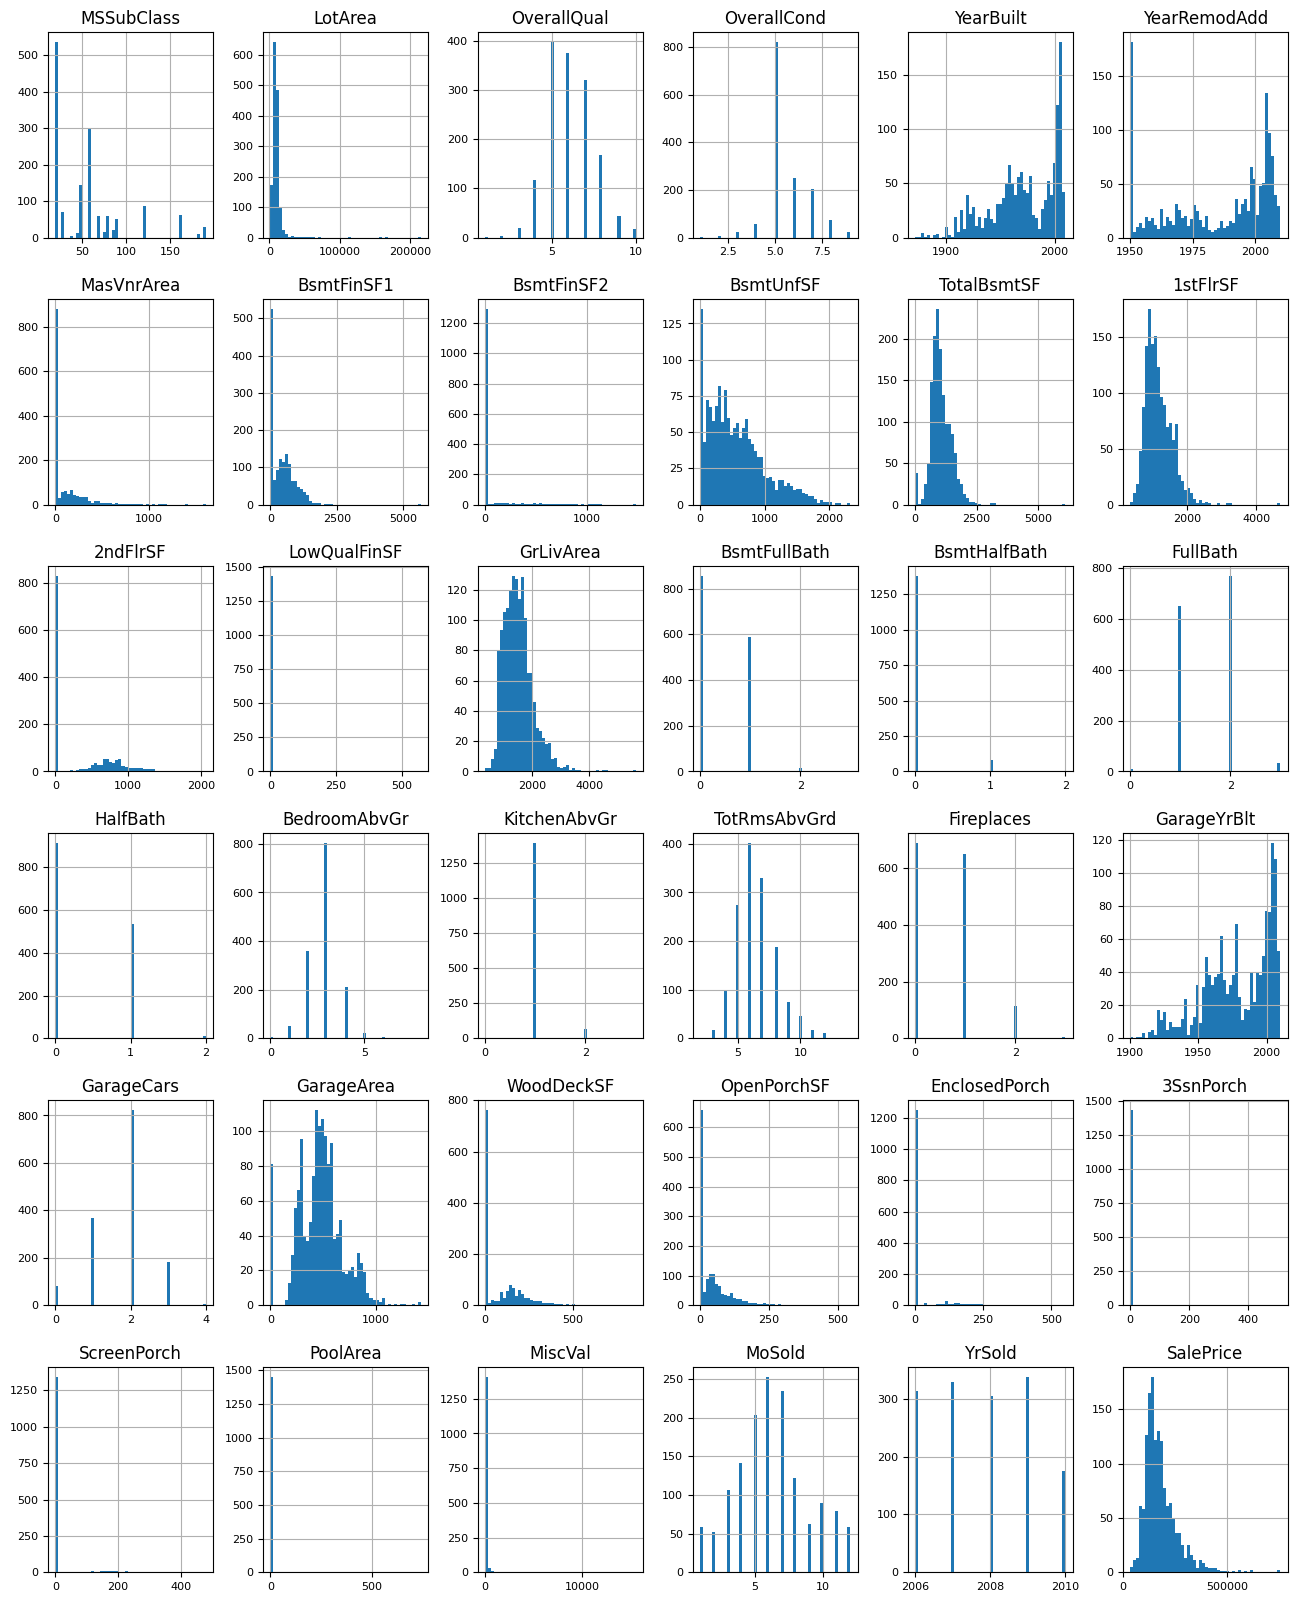

In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

### Tratamento de colunas vazias
- MasVnrType (tipo de alvenaria): Um valor ausente provavelmente significa que não há nenhum revestimento, ou seja, "None" (nenhum).
- MasVnrArea (area do revestimento externo em alvenaria): Para o tratamento dessa coluna utilizamos uma regra, caso a linha tenha MasVnrType como None, significa que não há área de revestimento, logo = 0. Para o resto preenchemos com a mediana dos valores.
- Colunas de BSMT: Para essas colunas primeiro preenchemos como none caso a área seja 0 e depois preenchemos com a moda para os valores restantes
- Colunas de garagem: Para catégoricas preenchemos com None e para numericas preenchemos com 0
- Electrical: Preenchimento com o tipo de rede mais comum no dataset

In [ ]:

# Listas de colunas categóricas relacionadas ao porão
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# Tratamento MasVnrType e MasVnrArea

df['MasVnrType'] = df['MasVnrType'].fillna('None')

df.loc[(df['MasVnrType'] == 'None') & (df['MasVnrArea'].isnull()), 'MasVnrArea'] = 0
mediana_area = df.loc[df['MasVnrArea'] > 0, 'MasVnrArea'].median()
df['MasVnrArea'] = df['MasVnrArea'].fillna(mediana_area)


for col in bsmt_cols:
    df.loc[(df['TotalBsmtSF'] == 0) & (df[col].isnull()), col] = 'None'

for col in bsmt_cols:
    if df[col].isnull().sum() > 0:
        moda = df[col].mode()[0]
        df[col] = df[col].fillna(moda)

# Tratamento Garage
for col in garage_cols:
    df[col] = df[col].fillna('None')
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

# Tratamento Electrical
df['Electrical'] = df['Electrical'].fillna('SBrkr')  # Mais comum

# Check
print(df.isnull().sum().sort_values(ascending=False).head(20))

MSSubClass      0
MSZoning        0
LotArea         0
Street          0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
OverallQual     0
OverallCond     0
YearBuilt       0
YearRemodAdd    0
RoofStyle       0
RoofMatl        0
dtype: int64


### Normalização dos dados
Para colunas numericas normalizamos os dados utilizando a tecnica min-max e para colunas categóricas utilizamos one hot encoding

In [ ]:
numerical_features = [
    'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
    'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
    'MiscVal', 'MoSold', 'YrSold'
]


In [ ]:
data = df.copy()

# Dicionário para armazenar os min e max de cada feature
normalization_stats = {}

# Aplicando Min-Max normalization
for feature in numerical_features:
    min_value = data[feature].min()
    max_value = data[feature].max()

    # Guardar os valores para possível reversão depois
    normalization_stats[feature] = {'min': min_value, 'max': max_value}

    # Normalização
    data[feature] = (data[feature] - min_value) / (max_value - min_value)

In [ ]:
# Transformação logarítmica no alvo
data['SalePrice'] = np.log1p(data['SalePrice'])

Shape antes do encoding: (1460, 74)
Shape depois do encoding: (1460, 279)


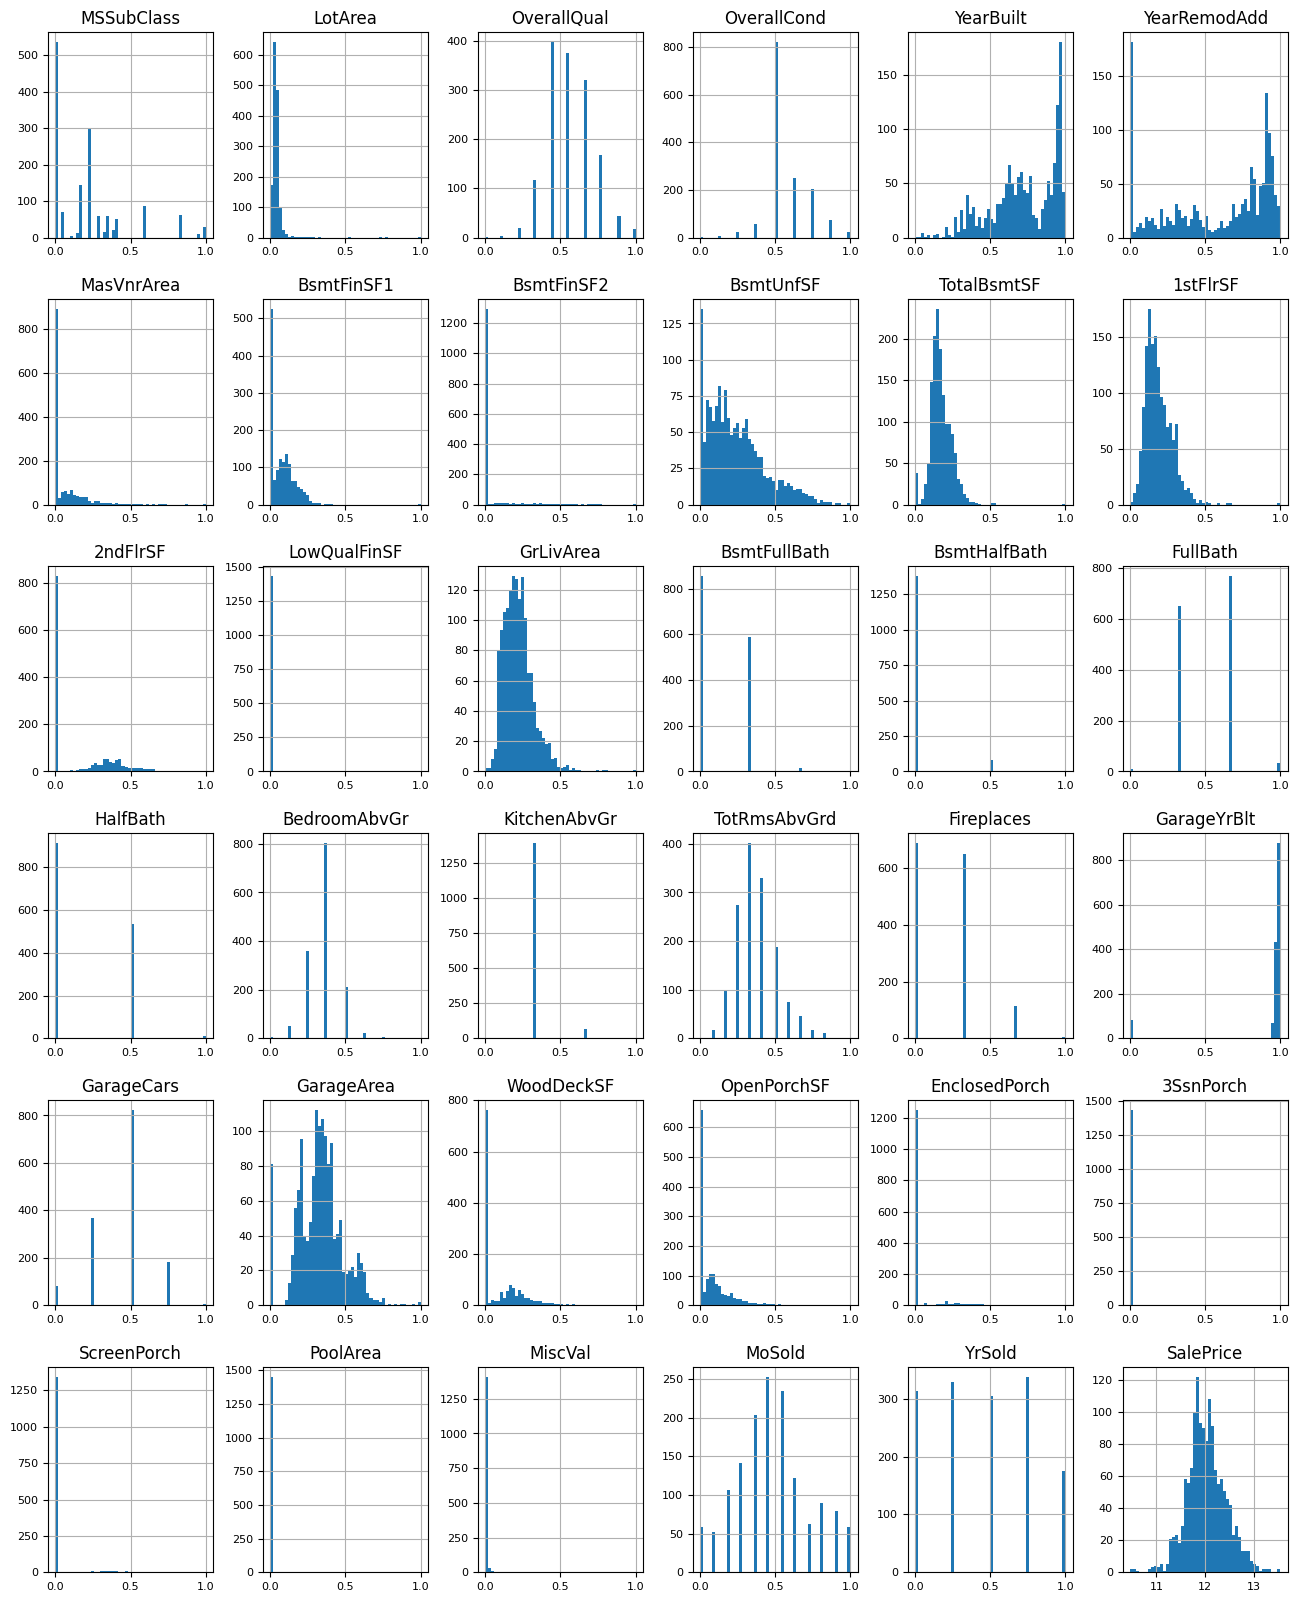

In [ ]:
# One-hot encoding
categorical_features = [
    'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual',
    'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition'
]

data_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=False)
df_num = data_encoded.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)
print("Shape antes do encoding:", data.shape)
print("Shape depois do encoding:", data_encoded.shape)

### Separando os dados de treino e teste

In [ ]:
X = data_encoded.drop(columns=['SalePrice'])
y = data_encoded['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.3, random_state=42)

### Head do dataset após o tratamento

In [ ]:
df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


# Criação da Rede

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.layer1 = nn.Linear(input_size, 32)
        self.layer2 = nn.Linear(32, 16)
        self.layer3 = nn.Linear(16, 1)
        self.activation = nn.ReLU()

        nn.init.kaiming_normal_(self.layer1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)

    def forward(self, x):
        x = self.dropout(self.activation(self.layer1(x)))
        x = self.dropout(self.activation(self.layer2(x)))
        return self.layer3(x)

## Treinamento do modelo e comparação de otimizadores

### Otimizador ADAM

In [ ]:
def train_model_house_adam(model, X_train, y_train, X_test, y_test, EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE):
    model.to(DEVICE)
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), LEARNING_RATE)

    train_losses, test_losses = [], []
    num_batches = len(X_train) // BATCH_SIZE

    pbar = tqdm(total=EPOCHS, desc='Training', unit='epoch')
    for epoch in range(EPOCHS):
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        epoch_train_loss = 0.0
        for i in range(0, X_train.size()[0], BATCH_SIZE):
            optimizer.zero_grad()
            indices = permutation[i:i+BATCH_SIZE]
            batch_X, batch_y = X_train[indices], y_train[indices]
            y_pred = model(batch_X)
            loss = ((y_pred - batch_y) ** 2).mean()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
        epoch_train_loss /= num_batches

        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = ((y_test_pred - y_test) ** 2).mean()

        train_losses.append(epoch_train_loss)
        test_losses.append(test_loss.item())
        pbar.set_postfix({'Train Loss': f'{epoch_train_loss:.6f}', 'Test Loss': f'{test_loss.item():.6f}'})
        pbar.update(1)
    pbar.close()
    return train_losses, test_losses

### Otimizador SGB

In [ ]:


def train_model_house_sgd(model, X_train, y_train, X_test, y_test, EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE, MOMENTUM=0.9):
    model.to(DEVICE)
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
    # SGD com momento
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

    train_losses, test_losses = [], []
    num_batches = len(X_train) // BATCH_SIZE

    pbar = tqdm(total=EPOCHS, desc='Training (SGD)', unit='epoch')
    for epoch in range(EPOCHS):
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        epoch_train_loss = 0.0

        for i in range(0, X_train.size()[0], BATCH_SIZE):
            optimizer.zero_grad()
            indices = permutation[i:i+BATCH_SIZE]
            batch_X, batch_y = X_train[indices], y_train[indices]
            y_pred = model(batch_X)
            loss = ((y_pred - batch_y) ** 2).mean()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= num_batches

        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = ((y_test_pred - y_test) ** 2).mean()

        train_losses.append(epoch_train_loss)
        test_losses.append(test_loss.item())
        pbar.set_postfix({'Train Loss': f'{epoch_train_loss:.6f}', 'Test Loss': f'{test_loss.item():.6f}'})
        pbar.update(1)

    pbar.close()
    return train_losses, test_losses




### RMS PROP

In [ ]:
def train_model_house_rmsprop(model, X_train, y_train, X_test, y_test, EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE, ALPHA=0.99, EPS=1e-08):
    model.to(DEVICE)
    X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
    X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
    # RMSprop com parâmetros padrão ajustáveis
    optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE, alpha=ALPHA, eps=EPS)

    train_losses, test_losses = [], []
    num_batches = len(X_train) // BATCH_SIZE

    pbar = tqdm(total=EPOCHS, desc='Training (RMSprop)', unit='epoch')
    for epoch in range(EPOCHS):
        model.train()
        permutation = torch.randperm(X_train.size()[0])
        epoch_train_loss = 0.0

        for i in range(0, X_train.size()[0], BATCH_SIZE):
            optimizer.zero_grad()
            indices = permutation[i:i+BATCH_SIZE]
            batch_X, batch_y = X_train[indices], y_train[indices]
            y_pred = model(batch_X)
            loss = ((y_pred - batch_y) ** 2).mean()
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        epoch_train_loss /= num_batches

        model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = ((y_test_pred - y_test) ** 2).mean()

        train_losses.append(epoch_train_loss)
        test_losses.append(test_loss.item())
        pbar.set_postfix({'Train Loss': f'{epoch_train_loss:.6f}', 'Test Loss': f'{test_loss.item():.6f}'})
        pbar.update(1)

    pbar.close()
    return train_losses, test_losses


### Instanciando os modelos e treinando as redes

In [ ]:
model_adam = MLP(X_train.shape[1])

model_rms = MLP(X_train.shape[1])

model_sgd = MLP(X_train.shape[1])

In [ ]:
X_train_tensor = torch.tensor(X_train.values)
y_train_tensor = torch.tensor(y_train.values).reshape(-1, 1)
X_test_tensor = torch.tensor(X_test.values)
y_test_tensor = torch.tensor(y_test.values).reshape(-1, 1)

train_losses, test_losses = train_model_house_adam(
    model_adam, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE
)
#RMS PROP
train_losses_rms, test_losses_rms = train_model_house_sgd(
    model_rms, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE
)
#SGD
train_losses_sgd, test_losses_sgd = train_model_house_rmsprop(
    model_sgd, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,
    EPOCHS, LEARNING_RATE, BATCH_SIZE, DEVICE
)

Training (RMSprop): 100%|██████████| 500/500 [00:15<00:00, 32.41epoch/s, Train Loss=0.965246, Test Loss=0.056377]


### Tirando métricas de treinamento

In [ ]:
print(y_train_tensor.max())
print(y_train_tensor.min())

tensor(13.5211)
tensor(10.4603)


In [ ]:
train_mean = np.mean(train_losses, axis=0)
train_std  = np.std(train_losses, axis=0)
test_mean  = np.mean(test_losses, axis=0)
test_std   = np.std(test_losses, axis=0)

train_mean_rms = np.mean(train_losses_rms, axis=0)
train_std_rms  = np.std(train_losses_rms, axis=0)
test_mean_rms  = np.mean(test_losses_rms, axis=0)
test_std_rms   = np.std(test_losses_rms, axis=0)

train_mean_sgd = np.mean(train_losses_sgd, axis=0)
train_std_sgd  = np.std(train_losses_sgd, axis=0)
test_mean_sgd  = np.mean(test_losses_sgd, axis=0)
test_std_sgd   = np.std(test_losses_sgd, axis=0)

print(f'dados de treino e teste para cada otimizador')
print(f'ADAM: train_mean: {train_mean:.2f}, train_std: {train_std:.2f}, test_mean: {test_mean:.2f}, test_std: {test_std:.2f}')
print(f'RMS PROP: train_mean: {train_mean_rms:.2f}, train_std: {train_std_rms:.2f}, test_mean: {test_mean_rms:.2f}, test_std: {test_std_rms:.2f}')
print(f'SGD: train_mean: {train_mean_sgd:.2f}, train_std: {train_std_sgd:.2f}, test_mean: {test_mean_sgd:.2f}, test_std: {test_std_sgd:.2f}')

dados de treino e teste para cada otimizador
ADAM: train_mean: 4.58, train_std: 7.25, test_mean: 0.52, test_std: 4.85
RMS PROP: train_mean: 0.57, train_std: 3.51, test_mean: 0.22, test_std: 0.51
SGD: train_mean: 3.15, train_std: 2.24, test_mean: 0.18, test_std: 0.20


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_losses, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(y=test_losses, mode='lines', name='Test Loss'))
fig.update_layout(title='Training and Test Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_losses_rms, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(y=test_losses_rms, mode='lines', name='Test Loss'))
fig.update_layout(title='Training and Test Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_losses_sgd, mode='lines', name='Training Loss'))
fig.add_trace(go.Scatter(y=test_losses_sgd, mode='lines', name='Test Loss'))
fig.update_layout(title='Training and Test Losses', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

### Avaliação de métricas

In [ ]:
model_adam.eval()
with torch.no_grad():
    y_pred = model_adam(X_test_tensor)

model_rms.eval()
with torch.no_grad():
    y_pred_rms = model_rms(X_test_tensor)

model_sgd.eval()
with torch.no_grad():
    y_pred_sgd = model_sgd(X_test_tensor)

# Desnormaliza as previsões
y_pred_denorm = torch.expm1(y_pred)
y_test_denorm = torch.expm1(y_test_tensor)

y_pred_denorm_rms = torch.expm1(y_pred_rms)
y_test_denorm = torch.expm1(y_test_tensor)

y_pred_denorm_sgd = torch.expm1(y_pred_sgd)
y_test_denorm = torch.expm1(y_test_tensor)

In [ ]:
# Compute Mean Absolute Error (MAE) of original values
mae = torch.mean(torch.abs(y_pred_denorm.reshape(-1).to("cpu") - y_test_denorm.reshape(-1).to("cpu")))
print(f"Mean Absolute Error (MAE) ADAM: {mae.item()}")

mae = torch.mean(torch.abs(y_pred_denorm_rms.reshape(-1).to("cpu") - y_test_denorm.reshape(-1).to("cpu")))
print(f"Mean Absolute Error (MAE) RMS PROP: {mae.item()}")

mae = torch.mean(torch.abs(y_pred_denorm_sgd.reshape(-1).to("cpu") - y_test_denorm.reshape(-1).to("cpu")))
print(f"Mean Absolute Error (MAE) SGD: {mae.item()}")

Mean Absolute Error (MAE) ADAM: 43680.66796875
Mean Absolute Error (MAE) RMS PROP: 31069.4375
Mean Absolute Error (MAE) SGD: 35569.07421875


In [ ]:
print("\n--- Gerando predições para test.csv ---")

# Carrega o test.csv
url_train = '/content/test.csv'
df_test = pd.read_csv(url_train)

id_values = df_test['Id'].copy()


--- Gerando predições para test.csv ---


### Tratando os dados de teste

In [ ]:
df_test.drop(columns=colunas_remover, inplace=True)

for col in bsmt_cols:
    df_test[col] = df_test[col].fillna('None')
for col in garage_cols:
    df_test[col] = df_test[col].fillna('None')

df_test['MasVnrType'] = df_test['MasVnrType'].fillna('None')
df_test['MasVnrArea'] = df_test['MasVnrArea'].fillna(0)
df_test['GarageYrBlt'] = df_test['GarageYrBlt'].fillna(0)
df_test['Electrical'] = df_test['Electrical'].fillna('SBrkr')



# Normalização das features numéricas
for feature in numerical_features:
    min_val = normalization_stats[feature]['min']
    max_val = normalization_stats[feature]['max']
    if max_val - min_val == 0:
        df_test[feature] = 0
    else:
        df_test[feature] = (df_test[feature] - min_val) / (max_val - min_val)

# One-hot encoding com alinhamento de colunas
df_test_encoded = pd.get_dummies(df_test, columns=categorical_features, drop_first=False)

# Garante que todas as colunas do treino estejam presentes no teste
for col in X_train.columns:
    if col not in df_test_encoded.columns:
        df_test_encoded[col] = 0

# Garante a ordem correta das colunas
df_test_encoded = df_test_encoded[X_train.columns]

# Corrige NaNs restantes
df_test_encoded = df_test_encoded.fillna(0)

# Converte para tensor
df_test_encoded = df_test_encoded.astype(np.float32)  # ✅ força tipos numéricos
X_test_real_tensor = torch.tensor(df_test_encoded.values, dtype=torch.float32)

In [ ]:
model_sgd.eval()
with torch.no_grad():
    y_pred_final = model_sgd(X_test_real_tensor)

# Desnormaliza
y_pred_final_denorm = torch.expm1(y_pred_final)

# Cria DataFrame de submissão
submission = pd.DataFrame({
    'Id': id_values.values,
    'SalePrice': y_pred_final_denorm.cpu().numpy().flatten()
})

# Salvar o arquivo CSV
submission.to_csv("submissao_final.csv", index=False)
print("✅ CSV salvo como 'submissao_final.csv'")

# Código específico do Colab para fazer o download do arquivo
from google.colab import files
files.download("submissao_final.csv")

✅ CSV salvo como 'submissao_final.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Importancia das variáveis
#### Como medir a importância de cada variável?
Para definir a importancia de cada variável vamos usar a tecnica de importância por permutação.<br>
A técnica de permutação consiste em alterar aleatoriamente os valores de cada coluna e calcular o erro com relação ao original, assim, a coluna que tiver erro maior é aquela que tem mais importância no modelo.
- baseline loss: perda que seu modelo obtém ao fazer previsões no conjunto de dados sem nenhuma modificação

In [ ]:

criterio = nn.MSELoss()
with torch.no_grad(): # Desativa o cálculo de gradientes para economizar memória e tempo
    previsoes_linha_base = model_sgd(X_test_tensor)
    perda_linha_base = criterio(previsoes_linha_base, y_test_tensor).item() # .item() para obter o valor numérico

print(f"Perda MSE de Linha de Base (original): {perda_linha_base:.4f}")

importancias_features = {}

# Iterar sobre cada feature para calcular a importância por permutação
for i, nome_feature in enumerate(X_test.columns):
    # Cria uma cópia do tensor de dados de teste para não modificar o original
    X_test_embaralhado = X_test_tensor.clone()

    # Embaralha os valores da coluna da feature atual
    indices_embaralhados = torch.randperm(X_test_embaralhado.shape[0])
    X_test_embaralhado[:, i] = X_test_embaralhado[indices_embaralhados, i]

    # Faz previsões com os dados embaralhados
    with torch.no_grad():
        previsoes_embaralhadas = model_sgd(X_test_embaralhado)
        perda_embaralhada = criterio(previsoes_embaralhadas, y_test_tensor).item()

    # A importância é o aumento na perda devido ao embaralhamento
    importancia = perda_embaralhada - perda_linha_base
    importancias_features[nome_feature] = importancia

# Classificar as features pela importância (do mais importante para o menos importante)
importancias_ordenadas = sorted(importancias_features.items(), key=lambda item: item[1], reverse=True)

print('Top 10 features com maior importância')
for feature, importancia in importancias_ordenadas[:10]: # Exibe apenas as 10 mais importantes
    print(f"- {feature}: {importancia:.4f}")


Perda MSE de Linha de Base (original): 0.0564
Top 10 features com maior importância
- BsmtQual_TA: 0.0039
- KitchenQual_Gd: 0.0036
- OverallQual: 0.0036
- 2ndFlrSF: 0.0034
- GrLivArea: 0.0032
- 1stFlrSF: 0.0029
- BsmtQual_Ex: 0.0027
- YearRemodAdd: 0.0027
- KitchenQual_Ex: 0.0027
- Neighborhood_Edwards: 0.0026
